In [1]:
import sys
import os
from pathlib import Path

sys.path.append(os.path.abspath(".."))

import torch
import numpy as np
import umap
import matplotlib.pyplot as plt


from utils.data import (
    download_mnist_data,
    get_mnist_image_np_arrays,
    get_mnnist_labels_np_arrays,
    UMAPImageDataset,
    ClassificationDataset,
)
from utils.autoencoder import MNISTAutoencoder
from utils.loss import UMAPAutoencoderLoss
from utils.train_functions import (
    train_autoencoder,
    train_autoencoder_with_umap,
    test_autoencoder_reconstruction,
    test_autoencoder_umap_embedding,
)

# Load MNIST images

In [2]:
# Skips downloading if data is already present
download_mnist_data()

Data is already downloaded. Skipping download.


In [3]:
train_images, test_images = get_mnist_image_np_arrays()

# UMAP embeddings

## Generate  & save embeddings

In [4]:
embedding_dim = 2

full_images = np.concatenate([train_images, test_images], axis=0)
flat_full_images = full_images.reshape(full_images.shape[0], -1)
reducer = umap.UMAP(n_components=embedding_dim)
full_embeddings = reducer.fit_transform(flat_full_images)

train_embeddings = full_embeddings[: len(train_images)]
test_embeddings = full_embeddings[len(train_images) :]

In [5]:
# Save full embeddings to a file
project_dir = Path("..").resolve()
embeddings_file = (
    project_dir
    / "data"
    / "mnist"
    / "umap_embeddings"
    / f"embeddings_d{embedding_dim}.npy"
)
embeddings_file.parent.mkdir(parents=True, exist_ok=True)
np.save(embeddings_file, full_embeddings)


## Load embeddings (if already saved)

In [6]:
embedding_dim = 2

project_dir = Path("..").resolve()
data_dir = project_dir / "data" / "mnist" / "umap_embeddings"
embeddings_file = data_dir / f"embeddings_d{embedding_dim}.npy"

full_embeddings = np.load(embeddings_file)
full_images = np.concatenate([train_images, test_images], axis=0)
flat_full_images = full_images.reshape(full_images.shape[0], -1)

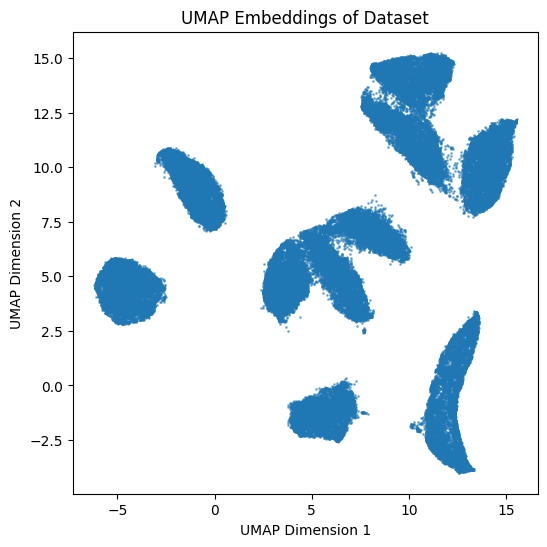

In [7]:
# Plot embeddings
plt.figure(figsize=(6, 6))
plt.scatter(full_embeddings[:, 0], full_embeddings[:, 1], s=1, alpha=0.5)
plt.title("UMAP Embeddings of Dataset")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


# Train Autoencoders

## Train & Test split

In [8]:
# Datasets
flat_train_images = train_images.reshape(train_images.shape[0], -1)
flat_test_images = test_images.reshape(test_images.shape[0], -1)

train_embeddings = full_embeddings[: len(train_images)]
test_embeddings = full_embeddings[len(train_images) :]

train_dataset = UMAPImageDataset(
    images=flat_train_images, umap_embeddings=train_embeddings
)
test_dataset = UMAPImageDataset(
    images=flat_test_images, umap_embeddings=test_embeddings
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

## Create models

In [9]:
input_dim = flat_full_images.shape[1]
umap_autoencoder = MNISTAutoencoder(input_dim=input_dim, embedding_dim=embedding_dim)
normal_autoencoder = MNISTAutoencoder(input_dim=input_dim, embedding_dim=embedding_dim)
print(umap_autoencoder)

MNISTAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


## Train normal Autoencoder

In [10]:
# Train
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(normal_autoencoder.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)

num_epochs = 5

train_autoencoder(
    model=normal_autoencoder,
    dataloader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
)

Epoch [1/5], Loss: 0.0545
Epoch [2/5], Loss: 0.0436
Epoch [3/5], Loss: 0.0417
Epoch [4/5], Loss: 0.0407
Epoch [5/5], Loss: 0.0398
Training complete.


## Train Autoencoder with UMAP as teacher

In [11]:
# Train
criterion = UMAPAutoencoderLoss(reconstruction_weight=0.5, umap_weight=0.5)
optimizer = torch.optim.Adam(umap_autoencoder.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)

num_epochs = 20

train_autoencoder_with_umap(
    model=umap_autoencoder,
    dataloader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
)


Epoch [1/20], Loss: 2.7741
Epoch [2/20], Loss: 0.7835
Epoch [3/20], Loss: 0.5635
Epoch [4/20], Loss: 0.4397
Epoch [5/20], Loss: 0.3659
Epoch [6/20], Loss: 0.3030
Epoch [7/20], Loss: 0.2550
Epoch [8/20], Loss: 0.2206
Epoch [9/20], Loss: 0.1882
Epoch [10/20], Loss: 0.1722
Epoch [11/20], Loss: 0.1470
Epoch [12/20], Loss: 0.1338
Epoch [13/20], Loss: 0.1158
Epoch [14/20], Loss: 0.1100
Epoch [15/20], Loss: 0.1017
Epoch [16/20], Loss: 0.0922
Epoch [17/20], Loss: 0.0872
Epoch [18/20], Loss: 0.0837
Epoch [19/20], Loss: 0.0787
Epoch [20/20], Loss: 0.0750
Training complete.


# Compare results

## Compare image results

### Plot normal Autoencoder results

In [26]:
# Plot example image and reconstructions
normal_autoencoder.eval()
with torch.no_grad():
    sample_images, _ = next(iter(test_loader))
    sample_images = sample_images.to(device).float()
    reconstructed = normal_autoencoder(sample_images).cpu().numpy()
    sample_images = sample_images.cpu().numpy()
    n = 20
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(sample_images[i].reshape(28, 28), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

RuntimeError: linear(): input and weight.T shapes cannot be multiplied (28x28 and 784x512)

### Plot UMAP Autoecoder results

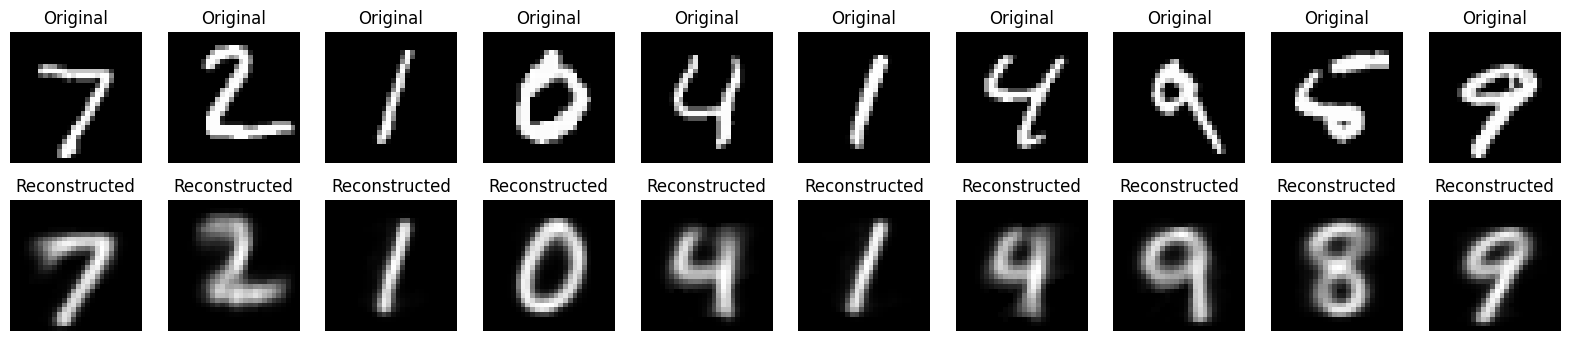

In [13]:
# Plot example image and reconstructions
umap_autoencoder.eval()
with torch.no_grad():
    sample_images, _ = next(iter(test_loader))
    sample_images = sample_images.to(device).float()
    reconstructed = umap_autoencoder(sample_images).cpu().numpy()
    sample_images = sample_images.cpu().numpy()
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(sample_images[i].reshape(28, 28), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()


## Compare Metrics

In [14]:
# Test
test_autoencoder_reconstruction(normal_autoencoder, test_loader, device)
test_autoencoder_reconstruction(umap_autoencoder, test_loader, device)

Test Reconstruction Loss: 0.0395
Test Reconstruction Loss: 0.0395


0.039485894954204556

In [15]:
test_autoencoder_umap_embedding(normal_autoencoder, test_loader, device)
test_autoencoder_umap_embedding(umap_autoencoder, test_loader, device)

Test UMAP Embedding Loss: 93.0497
Test UMAP Embedding Loss: 0.7089


0.7088704392433166

## Compare latent spaces

### Normal Autoencoder latent space

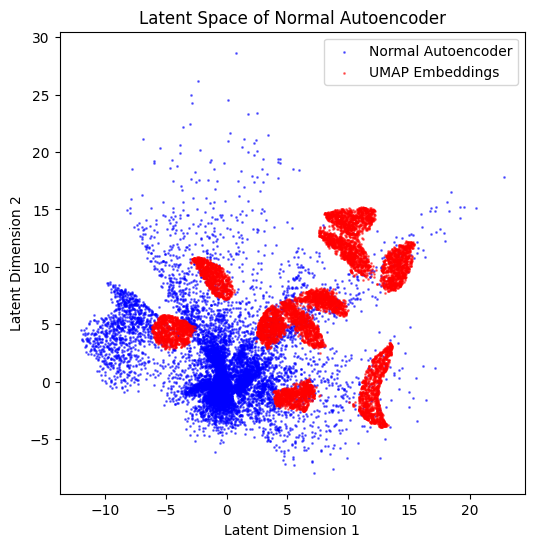

In [16]:
normal_autoencoder.eval()
all_latents = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device).float()
        latents = normal_autoencoder.encoder(images).cpu().numpy()
        all_latents.append(latents)
all_latents = np.concatenate(all_latents, axis=0)
plt.figure(figsize=(6, 6))
plt.scatter(
    all_latents[:, 0],
    all_latents[:, 1],
    s=1,
    alpha=0.5,
    color="blue",
    label="Normal Autoencoder",
)
plt.scatter(
    test_embeddings[:, 0],
    test_embeddings[:, 1],
    s=1,
    alpha=0.5,
    color="red",
    label="UMAP Embeddings",
)
plt.title("Latent Space of Normal Autoencoder")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend()
plt.show()

### UMAP Autoencoder latent space

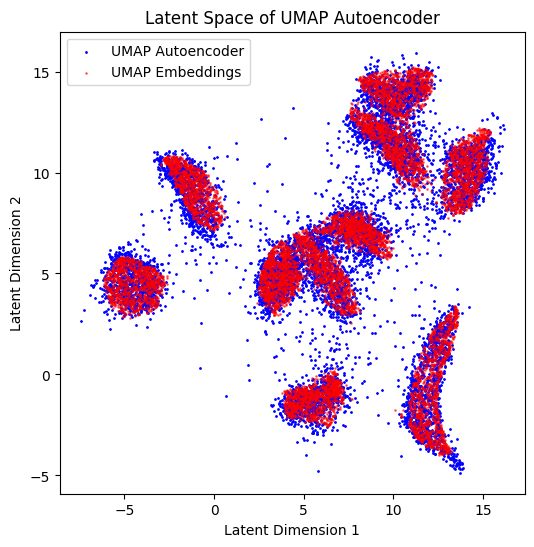

In [17]:
# Plot latent space of umap autoencoder
umap_autoencoder.eval()
all_latents = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device).float()
        latents = umap_autoencoder.encoder(images).cpu().numpy()
        all_latents.append(latents)
all_latents = np.concatenate(all_latents, axis=0)
plt.figure(figsize=(6, 6))
plt.scatter(
    all_latents[:, 0],
    all_latents[:, 1],
    s=1,
    alpha=1,
    color="blue",
    label="UMAP Autoencoder",
)
plt.scatter(
    test_embeddings[:, 0],
    test_embeddings[:, 1],
    s=1,
    alpha=0.5,
    color="red",
    label="UMAP Embeddings",
)
plt.title("Latent Space of UMAP Autoencoder")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend()
plt.show()

# Train Classification model and test on reconstructed data

In [18]:
class MLPClassifier(torch.nn.Module):
    def __init__(self, in_channels, num_classes):
        super(MLPClassifier, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels, 32, kernel_size=3, stride=2, padding=1
            ),  # 28→14
            torch.nn.Dropout(0.5),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 14→7
            torch.nn.Dropout(0.5),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, num_classes, kernel_size=7, stride=1, padding=0),  # 7→1
            torch.nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.layers(x)
        return x.squeeze()

In [19]:
def train_classifier(model, dataloader, criterion, optimizer, num_epochs, device):
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs = inputs.float().to(device)
            labels = labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")


In [20]:
train_labels, test_labels = get_mnnist_labels_np_arrays()

In [21]:
classifier = MLPClassifier(in_channels=1, num_classes=10)

# flat_train_images = train_images.reshape(train_images.shape[0], -1)
# flat_test_images = test_images.reshape(test_images.shape[0], -1)

train_images = train_images.reshape(-1, 1, 28, 28)
test_images = test_images.reshape(-1, 1, 28, 28)

train_dataset = ClassificationDataset(images=train_images, labels=train_labels)
test_dataset = ClassificationDataset(images=test_images, labels=test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)

num_epochs = 5
train_classifier(
    model=classifier,
    dataloader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
)

Epoch 1/5, Loss: 1.6554
Epoch 2/5, Loss: 1.5447
Epoch 3/5, Loss: 1.5269
Epoch 4/5, Loss: 1.5169
Epoch 5/5, Loss: 1.5118


In [22]:
def test_classification(model, dataloader, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.float().to(device)
            labels = labels.float().to(device)

            outputs = model(inputs)

            pred_class = torch.argmax(outputs, dim=1)
            true_class = torch.argmax(labels, dim=1)

            correct += (pred_class == true_class).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")

In [23]:
test_classification(classifier, test_loader, device)

Accuracy: 96.97%


In [24]:
# Test on normal autoencoders reconstructed data
reconstructed_train_images = []
normal_autoencoder.eval()
with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device).float()
        flat_images = images.view(images.size(0), -1)
        reconstructed = normal_autoencoder(flat_images).cpu().numpy()
        reconstructed = reconstructed.reshape(-1, 1, 28, 28)
        reconstructed_train_images.append(reconstructed)
reconstructed_train_images = np.concatenate(reconstructed_train_images, axis=0)
reconstructed_train_dataset = ClassificationDataset(
    images=reconstructed_train_images, labels=train_labels
)
reconstructed_train_loader = torch.utils.data.DataLoader(
    reconstructed_train_dataset, batch_size=128, shuffle=False
)
test_classification(classifier, reconstructed_train_loader, device)

Accuracy: 10.17%


In [25]:
# Test on umap autoencoders reconstructed data
reconstructed_train_images = []
umap_autoencoder.eval()
with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device).float()
        flat_images = images.view(images.size(0), -1)
        reconstructed = umap_autoencoder(flat_images).cpu().numpy()
        reconstructed = reconstructed.reshape(-1, 1, 28, 28)
        reconstructed_train_images.append(reconstructed)
reconstructed_train_images = np.concatenate(reconstructed_train_images, axis=0)
reconstructed_train_dataset = ClassificationDataset(
    images=reconstructed_train_images, labels=train_labels
)
reconstructed_train_loader = torch.utils.data.DataLoader(
    reconstructed_train_dataset, batch_size=128, shuffle=False
)
test_classification(classifier, reconstructed_train_loader, device)


KeyboardInterrupt: 